# The Vanishing Gradient Problem

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from util import relu, error_rate, getKaggleMNIST, init_weights

In [2]:
class HiddenLayer(object):
    def __init__(self, D, M):
        W = init_weights((D, M))
        b = np.zeros(M)
        self.W = theano.shared(W)
        self.b = theano.shared(b)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.sigmoid(X.dot(self.W) + self.b)

In [7]:
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=0.01, mu=0.99, epochs=30, batch_sz=100):
        N, D = X.shape
        K = len(set(Y))

        self.hidden_layers = []
        mi = D
        for mo in self.hidden_layer_sizes:
            h = HiddenLayer(mi, mo)
            self.hidden_layers.append(h)
            mi = mo

        # initialize logistic regression layer
        W = init_weights((mo, K))
        b = np.zeros(K)
        self.W = theano.shared(W)
        self.b = theano.shared(b)

        self.params = [self.W, self.b]
        self.allWs = []
        for h in self.hidden_layers:
            self.params += h.params
            self.allWs.append(h.W)
        self.allWs.append(self.W)

        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')
        pY = self.forward(X_in)

        cost = -T.mean( T.log(pY[T.arange(pY.shape[0]), targets]) )
        prediction = self.predict(X_in)
        # cost_predict_op = theano.function(
        #     inputs=[X_in, targets],
        #     outputs=[cost, prediction],
        # )

        dparams = [theano.shared(p.get_value()*0) for p in self.params]
        grads = T.grad(cost, self.params)

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]
        train_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],
            updates=updates,
        )

        n_batches = N / batch_sz
        costs = []
        lastWs = [W.get_value() for W in self.allWs]
        W_changes = []
        print ("supervised training...")
        for i in range(int(epochs)):
            print ("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(int(n_batches)):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                c, p = train_op(Xbatch, Ybatch)
                if j % 100 == 0:
                    print ("j / n_batches:", j, "/", n_batches, "cost:", c, "error:", error_rate(p, Ybatch))
                costs.append(c)

                # log changes in all Ws
                W_change = [np.abs(W.get_value() - lastW).mean() for W, lastW in zip(self.allWs, lastWs)]
                W_changes.append(W_change)
                lastWs = [W.get_value() for W in self.allWs]

        W_changes = np.array(W_changes)
        plt.subplot(2,1,1)
        for i in range(W_changes.shape[1]):
            plt.plot(W_changes[:,i], label='layer %s' % i)
        plt.legend()
        # plt.show()

        plt.subplot(2,1,2)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        Y = T.nnet.softmax(Z.dot(self.W) + self.b)
        return Y

supervised training...
epoch: 0
j / n_batches: 0 / 410.0 cost: 2.341391721004479 error: 0.9
j / n_batches: 100 / 410.0 cost: 2.3574872676083345 error: 0.9
j / n_batches: 200 / 410.0 cost: 2.301575629924423 error: 0.89
j / n_batches: 300 / 410.0 cost: 2.298286594655491 error: 0.88
j / n_batches: 400 / 410.0 cost: 2.298375732101419 error: 0.91
epoch: 1
j / n_batches: 0 / 410.0 cost: 2.3043720629054016 error: 0.86
j / n_batches: 100 / 410.0 cost: 2.30891806720224 error: 0.88
j / n_batches: 200 / 410.0 cost: 2.2961686467011377 error: 0.82
j / n_batches: 300 / 410.0 cost: 2.3168475795196217 error: 0.94
j / n_batches: 400 / 410.0 cost: 2.3029717594495893 error: 0.88
epoch: 2
j / n_batches: 0 / 410.0 cost: 2.3272877975258144 error: 0.89
j / n_batches: 100 / 410.0 cost: 2.2953590825470847 error: 0.84
j / n_batches: 200 / 410.0 cost: 2.3156640007759983 error: 0.9
j / n_batches: 300 / 410.0 cost: 2.312399534099112 error: 0.91
j / n_batches: 400 / 410.0 cost: 2.2980735778131662 error: 0.84
epoch:

j / n_batches: 100 / 410.0 cost: 0.10357067308887485 error: 0.04
j / n_batches: 200 / 410.0 cost: 0.06358817953662803 error: 0.02
j / n_batches: 300 / 410.0 cost: 0.22502699958928105 error: 0.08
j / n_batches: 400 / 410.0 cost: 0.1369264898223722 error: 0.07
epoch: 26
j / n_batches: 0 / 410.0 cost: 0.23538909668186914 error: 0.07
j / n_batches: 100 / 410.0 cost: 0.1583717444052073 error: 0.05
j / n_batches: 200 / 410.0 cost: 0.24525211189784277 error: 0.06
j / n_batches: 300 / 410.0 cost: 0.09288194554895161 error: 0.03
j / n_batches: 400 / 410.0 cost: 0.07509880221381332 error: 0.02
epoch: 27
j / n_batches: 0 / 410.0 cost: 0.2448222235856519 error: 0.05
j / n_batches: 100 / 410.0 cost: 0.07872984728990744 error: 0.02
j / n_batches: 200 / 410.0 cost: 0.22061674050623317 error: 0.06
j / n_batches: 300 / 410.0 cost: 0.2747103537269592 error: 0.07
j / n_batches: 400 / 410.0 cost: 0.16438690411742854 error: 0.04
epoch: 28
j / n_batches: 0 / 410.0 cost: 0.18958626964371578 error: 0.04
j / n

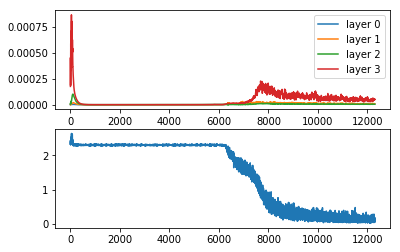

In [8]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
dnn = ANN([1000, 750, 500])
dnn.fit(Xtrain, Ytrain)